In [1]:
from time import time

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import time
import torch
import sklearn.datasets
import sklearn.preprocessing
import sklearn.model_selection
import numpy as np
import math
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as FMNIST
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
import tensorflow as tf
import random as r
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import time
import sys
import math
import numpy as np
import random
import joblib
from tqdm import tqdm_notebook
import copy

import Config
import Dataloader as DL

import matplotlib.pyplot as plt

In [2]:
datasets=[
    "KDD Cup 1999",                            #0
    "Microsoft Challenge BIG 2015"             #1
]
presets = {
    "KDD Cup 1999": {
        "NeuralHD": [300,2,3,.1],
        "OnlineHD": [300,1.0,.1,30,True],
        "MLP": [100,5,.001],
        "SVM": [10000]
    },
    "Microsoft Challenge BIG 2015": {
        "NeuralHD": [3000,6,10,.1],
        "OnlineHD": [3000,1.0,.1,30,True],
        "MLP": [100,30,.001],
        "SVM": [None]
    }
}
def normalized(x,y):
    xtrain, x_test, ytrain, y_test = None,None,None,None
    x, x_test, y, y_test = sklearn.model_selection.train_test_split(x, y, shuffle=True)
    scaler = sklearn.preprocessing.Normalizer().fit(x)
    x = scaler.transform(x)
    x_test = scaler.transform(x_test)

    # changes data to pytorch's tensors
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y).long()
    x_test = torch.from_numpy(x_test).float()
    y_test = torch.from_numpy(y_test).long()
    return x.numpy(), x_test.numpy(), y.numpy(), y_test.numpy(), scaler
def getuniquevalues(columnname,df):
    values={}
    i=0
    for entry in df[columnname]:
        if entry not in values:
            values[entry]=i
            i+=1
    return values
def get_dataset(name):
    if name==datasets[0]:
        path="../../Data/"
        attacks_types = {
            'normal': 'normal','back': 'dos','buffer_overflow': 'u2r','ftp_write': 'r2l','guess_passwd': 'r2l',
        'imap': 'r2l','ipsweep': 'probe','land': 'dos','loadmodule': 'u2r','multihop': 'r2l','neptune': 'dos',
        'nmap': 'probe','perl': 'u2r','phf': 'r2l','pod': 'dos','portsweep': 'probe','rootkit': 'u2r','satan': 'probe',
        'smurf': 'dos','spy': 'r2l','teardrop': 'dos','warezclient': 'r2l','warezmaster': 'r2l',
        }
        cols ="""duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,
        urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,
        num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,
        count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,
        diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,
        dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,
        dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate"""
        
        columns =[]
        for c in cols.split(','):
            if(c.strip()):
                columns.append(c.strip())
        print(len(columns))
        columns.append('target')
        print(len(columns))

        attack_categories=["dos","u2r","r2l",'probe','normal']
        df = pd.read_csv(path+"kddcup.data_10_percent.gz", names = columns)
        df['Attack Type'] = df.target.apply(lambda r:attacks_types[r[:-1]])
        del df['target']
        df.head()
        num_cols = df._get_numeric_data().columns
        
        cate_cols = list(set(df.columns)-set(num_cols))
        cate_cols.remove('Attack Type')
        for col in cate_cols:
            df[col]=df[col].map(getuniquevalues(col,df))
        data=df.to_numpy()
        Y=df['Attack Type'].map(getuniquevalues('Attack Type',df))
        Y=Y.to_numpy()
        X=data[:,:-1]
        print(Y.shape)
        print(X.shape)
        print(getuniquevalues('Attack Type',df))
        xtrain, x_test, ytrain, y_test,scaler= normalized(X,Y)
    if name==datasets[1]:
        path="../../Data/malware-classification/"
        map={}
        mapping=pd.read_csv(path + "trainLabels.csv")
        Y=mapping["Class"].to_numpy()
        for i in range(0,len(Y)):
            map[mapping["Id"][i]]=mapping["Class"][i]-1
        byte_features=pd.read_csv(path+"result.csv")
        byte_features['ID']  = byte_features['ID'].str.split('.').str[0]
        byte_features.head(3)
        byte_features['ID']=byte_features['ID'].map(map)
        data=byte_features.to_numpy()
        X=data[:,1:]
        Y=data[:,0]
        xtrain, x_test, ytrain, y_test,scaler= normalized(X,Y)
    return xtrain,x_test,ytrain,y_test

datasetname="Microsoft Challenge BIG 2015"

xtrain,x_test,ytrain,y_test=get_dataset(datasetname)


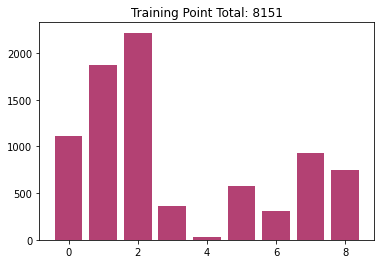

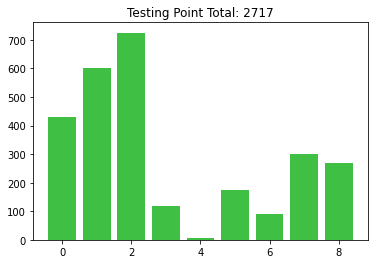

In [3]:
points=[]
for i in range (0,len(np.unique(ytrain))):
    points.append(len(xtrain[ytrain==i]))
plt.bar(range(0,len(points)),points, color=np.random.rand(3,))
plt.title("Training Point Total: " + str(sum(points)))
plt.show()
points=[]
for i in range (0,len(np.unique(y_test))):
    points.append(len(x_test[y_test==i]))
plt.bar(range(0,len(points)),points, color=np.random.rand(3,))
plt.title("Testing Point Total: " + str(sum(points)))
plt.show()

In [4]:
modeldict={}
def get_class_accuracy_breakdown(model,x_test,y_test, output=False):
    acc=[]
    points=[]
    try:
        for i in range (0,len(np.unique(y_test))):
            yhat= model.predict(x_test[y_test==i])
            if len(yhat.shape)==2:
                yhat=np.array([row.argmax() for row in yhat])
            acc.append((yhat==i).mean())
            points.append(len(yhat))
    except:
        for i in range (0,len(np.unique(y_test))):
            yhat= model.predict(torch.from_numpy(x_test[y_test==i]))
            acc.append((yhat==i).float().mean())
            points.append(len(yhat))
    # print(yhat[:30])
    totacc=sum([acc[i]*points[i] for i in range(0,len(acc))])/sum(points)
    if output:
        plt.bar(range(0,len(acc)),acc,color=np.random.rand(3,))
        plt.title("Accuracy Total: " + str(totacc))
        plt.show()
    return totacc

In [5]:
# Generate one random vector of desired length and generation type
def generate_vector(vector_length, vector_type, param):
    #Check for Gaussian kernel
    if vector_type == "Gaussian":
        #parse for mu
        mu = param["mu"]
        #parse for sigma
        sigma = param["sigma"]
        #return vector generated from kernel
        return np.random.normal(mu, sigma, vector_length)
    else:
        #all other kernels are currently unsupported
        raise Exception("Vector type %s not recognized. Abort.\n" % vector_type)

def vanilla(param):

    #create basis as list
    basis = []
    #hidden dimension is D
    for _ in range(param["D"]):
        #add one generated vector as a time
        basis.append(generate_vector(param["nFeatures"], param["vector"], param))
    #make basis numpy array
    basis = np.asarray(basis)
    return basis



        #sys.stderr.write(str(self.basis.shape)+"\n")
def updateBasis(basis, param, toChange = None):
    # print("Updating basis......")# at the following indices: (None means changing everything)")
    #print(toChange)
    #For each dimension designated to be dropped
    for i in toChange:
        #generate a new ith vector in the basis
        basis[i] = generate_vector(param["nFeatures"], param["vector"], param)
    return

In [29]:
import Config
import sys
import random
import numpy as np
import sklearn
from Config import config, Update_T

# n = e^-(|x|^2/(2std^2)) <- gaussian function
def gauss(x,y,std):
  n = np.linalg.norm(x - y)
  n = n ** 2
  n = n * -1
  n = n / (2 * (std**2))
  n = np.exp(n)
  return n

def poly(x,y,c,d):
  return (np.dot(x,y) + c) ** d

#  dot product/ gauss product/ cos product
def kernel(x,y):
  dotKernel = np.dot
#   gaussKernel = lambda x, y : gauss(x,y,25)
#   polyKernel = lambda x,y : poly(x,y,3,5)
#   cosKernel = lambda x,y : np.dot(x,y) / (np.linalg.norm(x) * np.linalg.norm(y))
  #k = gaussKernel
  #k = polyKernel
  k = dotKernel
  #k = cosKernel
  return k(x,y)

class HD_classifier:

    # Required parameters for the training it supports; will enhance later
    options = ["one_shot", "dropout", "lr"]
    # required opts for dropout
    options_dropout = ["dropout_rate", "update_type"]

    # id: id associated with the basis/encoded data
    def __init__(self, D, nClasses, id):
        self.D = D
        # number of classes
        self.nClasses = nClasses
        # classes
        self.classes = np.zeros((nClasses, D))
        self.counts = np.zeros(nClasses)
        # If first fit, print out complete configuration
        self.first_fit = True
        self.id = id
        self.idx_weights = np.ones((D))
        self.update_cnts = np.zeros((D))
        self.mask = np.ones((D))

    def getClasses(self):
        return self.classes

    def update(self, weight, mask, guess, answer, rate, update_type=Update_T.FULL):
        sample = weight * mask
        self.counts[guess] += 1
        self.counts[answer] += 1
        # update hypervector weights
        if update_type == Update_T.FULL:
            self.classes[guess]  -= rate * weight
            self.classes[answer] += rate * weight
        elif update_type == Update_T.PARTIAL:
            self.classes[guess]  -= rate * sample
            self.classes[answer] += rate * weight
        elif update_type == Update_T.RPARTIAL:
            self.classes[guess]  -= rate * weight
            self.classes[answer] += rate * sample
        elif update_type == Update_T.MASKED:
            self.classes[guess]  -= rate * sample
            self.classes[answer] += rate * sample
        elif update_type == Update_T.HALF:
            self.classes[answer] += rate * weight
            self.counts[guess] -= 1
        elif update_type == Update_T.WEIGHTED:
            self.classes[guess]  -= rate * np.multiply(self.idx_weights, sample)
            self.classes[answer] += rate * np.multiply(self.idx_weights, sample)
        else:
            raise Exception("unrecognized Update_T")

    # update class vectors with each sample, once
    # return train accuracy
    def fit(self, data, label, param = None):
        
        assert self.D == data.shape[1]

        # Default parameter
        if param is None:
            #set default configuration
            param = Config.config
        for option in self.options:
            if option not in param:
                #if options are missing, set it to default
                param[option] = config[option]
        #if self.first_fit:
        #    sys.stderr.write("Fitting with configuration: %s \n" % str([(k,param[k]) for k in self.options]))

        # Actual fitting

        # handling dropout
        mask = np.ones(self.D)
        if param["masked"]:
            mask = np.copy(self.mask)
        elif param["dropout"]:
            for option in self.options_dropout:
                if option not in param:
                    param[option] = config[option]
            # Mask for dropout
            for i in np.random.choice(self.D, int(self.D * (param["drop_rate"])), replace=False):
                mask[i] = 0

        # fit
        r = list(range(data.shape[0]))
        random.shuffle(r)
        correct = 0
        count = 0
        for i in r:
            sample = data[i] * mask
            assert data[i].shape == mask.shape

            answer = label[i]
            #maxVal = -1
            #guess = -1
            #for m in range(self.nClasses):
            #    val = kernel(self.classes[m], sample)
            #    if val > maxVal:
            #        maxVal = val
            #        guess = m
            vals = np.matmul(sample, self.classes.T)
            # print(vals)
            guess = np.argmax(vals)
            if guess != answer:
                self.update(data[i], mask, guess, answer, param["lr"], param["update_type"])
            else:
                correct += 1
            count += 1
        self.first_fit = False
        return correct / count
    def predict(self, data):
        # print(data.shape)
        assert self.D == data.shape[1]

        prediction = []
        # fit
        for i in range(0,data.shape[0]):
            maxVal = -1
            guess = -1
            for m in range(self.nClasses):
                val = kernel(self.classes[m], data[i])
                if val > maxVal:
                    maxVal = val
                    guess = m
            prediction.append(guess)
        return prediction

    # given current classifier value, return:
    # Variance of each dimension across the classes, and
    # The indices in the order from least variance to greatest
    def evaluateBasis(self):
        #normed_classes = self.classes/(np.sqrt(np.asarray([self.counts])).T)
        #variances = np.var(self.classes, axis = 0)
        normed_classes = sklearn.preprocessing.normalize(np.asarray(self.classes), norm='l2')
        variances = np.var(normed_classes, axis = 0) 
        assert len(variances) == self.D
        order = np.argsort(variances)
        return variances, order

    # Some basis are to be update
    def updateClasses(self, toChange = None):
        if toChange is None:
            #self.classes = np.zeros((self.nClasses, self.D))
            self.classes = sklearn.preprocessing.normalize(np.asarray(self.classes), norm='l2', axis = 0)
            self.counts = np.ones(self.nClasses) # An averaged vector is already in
        else:
            for i in toChange:
                self.classes[:,i] = np.zeros(self.nClasses)


In [30]:

# dump basis and its param into a file, return the name of file
def saveEncoded(encoded, labels, id = "", data_type = "unknown"):
    filename = "encoded_%s_%s.pkl" % (id, data_type)
    sys.stderr.write("Dumping data into %s \n"%filename)
    joblib.dump((encoded, labels), open(filename, "wb"), compress=True)
    return filename

# Load basis from a file
def loadEncoded(filename):
    encoded, labels = joblib.load(filename)
    return encoded, labels

def encode(x,basis, base, noise):
        n = x.size(0)
        bsize = min([n,1024])
        h = torch.empty(n, basis.shape[0], device=x.device, dtype=x.dtype)
        temp = torch.empty(bsize, basis.shape[0], device=x.device, dtype=x.dtype)

        # we need batches to remove memory usage
        for i in range(0, n, bsize):
            torch.matmul(x[i:i+bsize], basis.T, out=temp)
            if noise:
                torch.add(temp, base, out=h[i:i+bsize])#h[i:i+bsize]=temp# torch.add(temp, self.base, out=h[i:i+bsize])
            else:
                h[i:i+bsize]=temp
            h[i:i+bsize].cos_()#.mul_(temp.sin_())
        # print(h.shape)
        return h

# Class: HD_encoder
# Use: take in a basis and a noise flag to create instance, call functions to with data to encode
class HD_encoder:
    def __init__(self, basis, noise=False):
        # set basis to encode with
        self.basis = basis
        self.base = torch.empty(basis.shape[0]).uniform_(0.0, 2*math.pi)
        # hypervector dimension
        self.D = basis.shape[0]
        self.noise=noise
        #### Noise not implemented yet
        # self.noises = []  
        # if noise:
        #     self.noises = np.random.uniform(0, 2 * math.pi, self.D)
        # else:
        #     self.noises = np.zeros(self.D)

    #encode one vector/sample into a HD vector
    def encodeDatum(self, datum):
        #generate outputs
        encoded = np.matmul(self.basis, datum)
        #nonlinear activation function
        encoded = np.cos(encoded)
        #return results
        return encoded
    def encodeData(self, data):
        # print(self.basis.shape)
        # print(data.shape)
        #Changed it to do matmul for all data at once
        # encoded = np.matmul(self.basis,data.T).T
        # #nonlinear activation function
        # encoded = np.cos(encoded)
        # print(encoded.shape)
        return encode(torch.from_numpy(data).float(),torch.from_numpy(self.basis).float(),self.base,self.noise).numpy()#encoded
        # start = time.time()
        #no matrix multiplication errors
        assert data.shape[1] == self.basis.shape[1]
        # noises = []
        encoded = []

        for i in range(len(data)):
            encoded.append(self.encodeDatum(data[i]))

        # end = time.time()
        #sys.stderr.write("Time spent: %d sec\n" % int(end - start))
        return np.asarray(encoded)

    # Replace basis of the HDE
    def updateBasis(self, basis):
        self.basis = basis

In [31]:


class NeuralHD:
    def __init__(self, classes : int, features : int, dim : int = 400):
        #Configure for hdb, hdc, and hde classes
        self.param=Config.config
        self.param['nClasses'] = classes
        self.param['nFeatures']= features
        #hypervector size
        self.param['D']=dim
        #encoder
        self.hde=None
        #classifier
        self.hdc=None
        # Initialize basis
        basis = vanilla(self.param)
        # make encoder based on basis
        self.hde = HD_encoder(basis)
        # Initialize classification hypervectors
        self.hdc = HD_classifier(self.param["D"], self.param["nClasses"], 0)
    def __call__(self, x : torch.Tensor):
        #True iff the model has been trained
        assert self.hde!=None and self.hdc!=None
        #return predicted values
        return self.predict(x)
    def predict(self,x):
        # print(x.shape)
        #Get hypervectors for all data points
        trainencoded=self.hde.encodeData(x)
        #return predictions based on similarity to classification hypervectors
        return np.array(self.hdc.predict(trainencoded))
    def fit(self,traindata, trainlabels,
                   epochs,
                   regenloops,  # list of effective dimensions to reach 
                   percentDrop # drop/regen rate 
                    ):
        
        # find encoded training vectors
        trainencoded = self.hde.encodeData(traindata)

        # calculate amount of dropped dimensions based on percent and original dimension
        amountDrop = int(percentDrop * self.hdc.D)#self.param.D?
        # print("Updating times:", regenloops)

        for i in range(regenloops+1): # For each eDs to reach, will checkpoints
            # print("regenloop: " + str(i))
            # train for x epochs
            perfect=self.trainreploop(epochs,trainencoded,trainlabels)
            #if its the last regeneration training, stop before doing another dimension drop; stop if 100% accuracy
            if i==regenloops or perfect:
                return #self.hdc,self.hde - unnecessary now that hdc and hde are within a class
            # print(i)
            #do the dimension drop and regeneration
            trainencoded=self.regen(self.hde.basis,amountDrop,traindata)
        return "error","error"
    
    def trainreploop(self,epochs,trainencoded,trainlabels):
        # Do the train 
        for j in range(epochs):
            # do one pass of training
            train_acc = 100 * self.hdc.fit(trainencoded, trainlabels, self.param)
            #Test accuracy used to be in here but I took it out because we dont usually know it
            # print("Train: %.2f \t \t Test: "%(train_acc))
            # If accuracy is 100, finish
            if train_acc == 100:
                return True
        return False
    def regen(self,basis,amountDrop,traindata):
        #make order of dimensions according to variaince; also store variances <-- unnecessary?
        var, orders = self.hdc.evaluateBasis()
        #drop dimensions with lowest variance
        # print(sum(var)/len(var))
        # plt.plot(range(0,len(var)),var[orders])
        # plt.show()
        

        toDrop = orders[:amountDrop]
        # print("Variances stats: max %.2f, min %.2f, mean %.2f"%(max(var),min(var),np.mean(var)))
        #update basis by randomizing dimension
        updateBasis(basis,self.param,toDrop)
        # move the new basis into the encoder
        self.hde.updateBasis(basis)
        # normalize previous classes so retrain has enough effect
        self.hdc.updateClasses()
        # get new encoded training data
        return self.hde.encodeData(traindata)    

In [6]:
# model=NeuralHD(9,xtrain.shape[1],3000)
modelname="NeuralHD"
dimension=presets[datasetname][modelname][0]
iterations=5
regens=5
dropoutratio=.1
setup="model=NeuralHD(len(np.unique(y_test)),xtrain.shape[1],"+ str(dimension) +")"
exec(setup)
training="model.fit(xtrain,ytrain,"+str(iterations)+","+str(regens)+","+str(dropoutratio)+")" #6,10
exec(training)
modeldict[modelname]=[setup,training]

NameError: name 'NeuralHD' is not defined

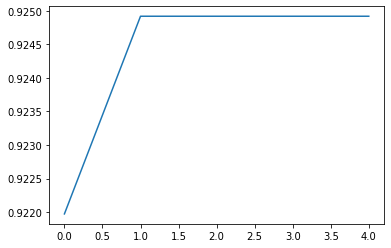

In [388]:
plt.plot(range(0,len(accuracies)),accuracies)
plt.show()

Can we alleviate the randomness with backwards dropout rates?

In [393]:
get_class_accuracy_breakdown(model,x_test,y_test)

0.9032020610967979

In [25]:
import onlinehd as Onlinehd
import warnings
modelname="OnlineHD"
dimension=presets[datasetname][modelname][0]
bootstrap=64
learningrate=presets[datasetname][modelname][2]
epochs=150
one_pass_fit=False
warnings.filterwarnings('ignore')
setup = "model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim="+str(dimension)+")"
exec(setup)
training="model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), bootstrap="+str(bootstrap)+", lr="+str(learningrate)+", epochs="+str(epochs)+", one_pass_fit="+str(one_pass_fit)+")"
exec(training)
modeldict[modelname]=[setup,training]

In [70]:
for i in range(0,10):
    model=None
    model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=1000)
    model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), bootstrap=bootstrap, lr=.037, epochs=50, one_pass_fit=False)
    print(get_class_accuracy_breakdown(model,x_test,y_test))

tensor(0.9308)
tensor(0.9474)
tensor(0.9238)
tensor(0.9510)
tensor(0.9430)
tensor(0.9426)
tensor(0.9463)
tensor(0.9518)
tensor(0.9308)
tensor(0.9242)


In [10]:
accuracies=[]
trainingtimes=[]
for i in range(0,11):
    bootstrap=2**i
    start=time.time()
    setup = "model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim="+str(dimension)+")"
    exec(setup)
    training="model.fit(torch.from_numpy(xtrain),torch.from_numpy(ytrain), bootstrap="+str(bootstrap)+", lr="+str(learningrate)+", epochs="+str(epochs)+", one_pass_fit="+str(one_pass_fit)+")"
    exec(training)
    end=time.time()
    accuracies.append(get_class_accuracy_breakdown(model,x_test,y_test))
    trainingtimes.append(end-start)

In [68]:
get_class_accuracy_breakdown(model,x_test,y_test)

tensor(0.9492)

In [66]:
start=time.time()
model.predict(torch.from_numpy(x_test))
end=time.time()
print(end-start)

0.03975105285644531


In [21]:
trainingtimes

[51.90499210357666,
 35.233017921447754,
 23.574031114578247,
 15.629335880279541,
 12.23548412322998,
 7.438483953475952,
 4.913514137268066,
 3.434682846069336,
 2.3217811584472656,
 1.8649909496307373,
 1.5347990989685059]

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 257)               66306     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               33024     
_________________________________________________________________
dense_20 (Dense)             (None, 9)                 1161      
Total params: 100,491
Trainable params: 100,491
Non-trainable params: 0
_________________________________________________________________
(8151, 257) (8151, 9)
Epoch 1/30
66/66 [==============================] - 1s 4ms/step - loss: 1.2149 - accuracy: 0.6521 - val_loss: 0.8952 - val_accuracy: 0.7394
Epoch 2/30
66/66 [==============================] - 0s 2ms/step - loss: 0.7625 - accuracy: 0.7725 - val_loss: 0.7224 - val_accuracy: 0.7805
Epoch 3/30
66/66 [==============================] - 0s 2ms/step - loss: 0.63

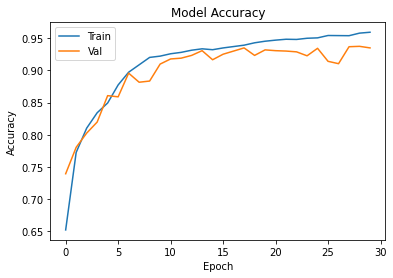

In [74]:
modelname="MLP"
batchsize=presets[datasetname][modelname][0]
epochs=presets[datasetname][modelname][1]
learningrate=presets[datasetname][modelname][2]
def plot_accuracies(hist):
    print("Final Accuracy: " + str(hist.history['accuracy'][len(hist.history['accuracy'])-1]))
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    if len(hist.history['accuracy'])==1:
        plt.plot([0], [hist.history['accuracy'][0]], marker='o', markersize=3, color="blue")
        plt.plot([0], [hist.history['val_accuracy'][0]], marker='o', markersize=3, color="orange")

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def runTraining(model, x_train, y_train, batchSize, epochs, learningRate):
  opt = RMSprop(learning_rate= learningRate)
  model.compile(optimizer = opt, loss= 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()
  print(np.shape(x_train), np.shape(y_train))
  history = model.fit(x_train, y_train,
                    batch_size = batchSize,
                    epochs = epochs, validation_split = .2, verbose = 1)
  plot_accuracies(history)
  return history.history['accuracy'][len(history.history['accuracy'])-1]

def setup_():
  model = Sequential()
  model.add(Dense(xtrain.shape[1], activation='relu', input_shape=(xtrain.shape[1],)))
  model.add(Dense(int(xtrain.shape[1]/2), activation='relu'))
  model.add(Dense(len(np.unique(y_test)), activation="softmax"))
  return model
def fit(model,xtrain,ytrain,batchsize,epochs,learningrate):
  ohe = sklearn.preprocessing.OneHotEncoder()
  transformed = ohe.fit_transform(np.expand_dims(ytrain,1))
  runTraining(model, xtrain, transformed.toarray(), batchsize, epochs, learningrate)
setup="model=setup_()"
exec(setup)
training="fit(model,xtrain,ytrain,"+str(batchsize)+","+str(epochs)+","+str(learningrate)+")"#100,30,.001
exec(training)
modeldict[modelname]=[setup,training]

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 0 8 8 8 8 8 8 8 8 8 3 8]


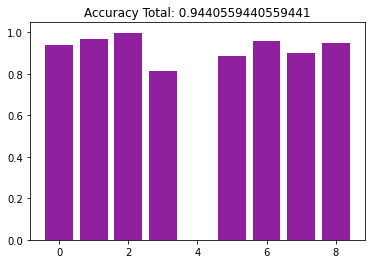

In [75]:
get_class_accuracy_breakdown(model,x_test,y_test)

In [76]:
from sklearn import pipeline
modelname="SVM"
datalimit=presets[datasetname][modelname][0]
setup="model = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.SVC(gamma='auto'))"
exec(setup)
training="model.fit(xtrain[:"+ str(datalimit or "") +"], ytrain[:"+str(datalimit or "") +"])"
exec(training)
modeldict[modelname]=[setup,training]

[8 8 8 1 8 8 8 1 8 8 8 8 8 8 8 8 8 8 0 1 8 8 8 8 8 8 8 8 2 1]


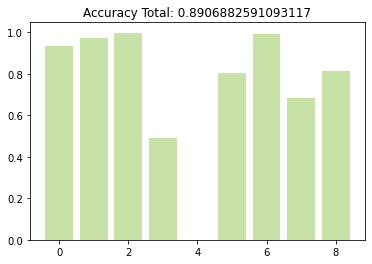

In [77]:
get_class_accuracy_breakdown(model,x_test,y_test)

In [158]:

modelexecs=[]
modelnames=[]
for key,value in modeldict.items():
    modelexecs.append(value)
    modelnames.append(key)

0
model = Onlinehd.OnlineHD(len(np.unique(y_test)), x_test.shape[1], dim=3000)
ekans <class 'onlinehd.onlinehd.OnlineHD'>
2.093048095703125
0.09137797355651855
tensor(0.8266)
1
model=setup_()
ekans <class 'tensorflow.python.keras.engine.sequential.Sequential'>
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 257)               66306     
_________________________________________________________________
dense_49 (Dense)             (None, 128)               33024     
_________________________________________________________________
dense_50 (Dense)             (None, 9)                 1161      
Total params: 100,491
Trainable params: 100,491
Non-trainable params: 0
_________________________________________________________________
(8151, 257) (8151, 9)
Epoch 1/30
66/66 [==============================] - 1s 3ms/step - loss: 1.2397 - accuracy: 0.6

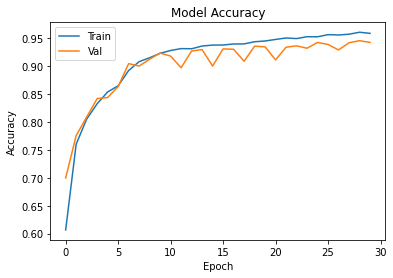

4.224864959716797
0.08707523345947266
0.9466323150533676
2
model = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.svm.SVC(gamma='auto'))
ekans <class 'sklearn.pipeline.Pipeline'>
2.647629976272583
2.2856240272521973
0.8906882591093117
3
model=NeuralHD(len(np.unique(y_test)),xtrain.shape[1],3000)
ekans <class '__main__.NeuralHD'>
Updating times: 6
regenloop: 0
regeneration
Updating basis......
regenloop: 1
regeneration
Updating basis......
regenloop: 2
regeneration
Updating basis......
regenloop: 3
regeneration
Updating basis......
regenloop: 4
regeneration
Updating basis......
regenloop: 5
regeneration
Updating basis......
regenloop: 6
11.120788812637329
0.13581609725952148
0.9068825910931174


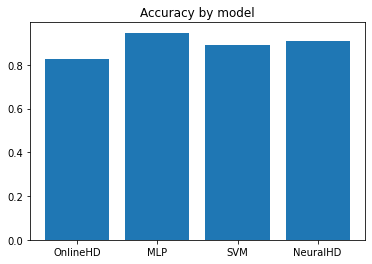

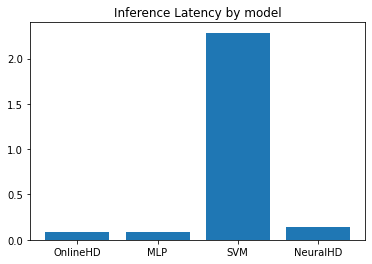

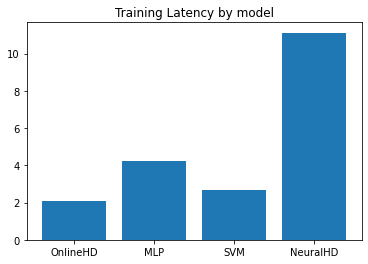

In [159]:
traininglatencies=[]
inferencelatencies=[]
accs=[]
for i in range(0,len(modelexecs)):
    yhat=None
    print(i)
    print(modelexecs[i][0])
    exec(modelexecs[i][0])
    print("ekans", type(model))
    start=time.time()
    exec(modelexecs[i][1])
    end = time.time()
    traininglatency=end-start
    print(traininglatency)
    traininglatencies.append(traininglatency)
    try:
        start=time.time()
        yhat=model.predict(x_test)
        end=time.time()
    except:
        start=time.time()
        yhat=model.predict(torch.from_numpy((x_test)))
        end=time.time()
    inferencelatency=end-start
    print(inferencelatency)
    inferencelatencies.append(inferencelatency)
    if len(yhat.shape)==2:
        yhat=np.array([row.argmax() for row in yhat])
    eval=[yhat[i]==y_test[i] for i in range(len(y_test))]
    acc=sum(eval)/len(y_test)
    print(acc)
    accs.append(acc)
plt.bar(modelnames,accs)
plt.title("Accuracy by model")
plt.show()
plt.bar(modelnames,inferencelatencies)
plt.title("Inference Latency by model")
plt.show()
plt.bar(modelnames,traininglatencies)
plt.title("Training Latency by model")
plt.show()

In [83]:
base = torch.empty(100).uniform_(0.0, 2*math.pi)
base

tensor([0.0896, 3.6227, 4.3752, 4.9817, 2.8063, 1.9133, 3.2085, 3.7869, 5.1253,
        3.3032, 3.0802, 1.4958, 5.2226, 5.8879, 4.7670, 1.1844, 2.0562, 3.9958,
        2.8611, 5.7673, 4.4283, 2.0349, 5.9857, 0.3350, 4.2482, 2.2704, 5.7467,
        1.3365, 2.3431, 3.9906, 0.1821, 0.2825, 2.1377, 2.1720, 4.0624, 0.7961,
        2.5138, 2.5185, 5.7470, 1.6266, 3.4089, 4.7303, 4.3464, 4.9270, 2.5466,
        0.5581, 2.9040, 2.2172, 1.3333, 2.2763, 0.0282, 1.2282, 5.8908, 2.4658,
        0.0348, 2.8463, 0.2769, 5.9795, 3.9533, 0.8936, 0.4039, 3.7111, 2.5136,
        4.8631, 3.0907, 1.3999, 5.3088, 1.2471, 3.5218, 0.7728, 0.1808, 6.0663,
        6.0172, 5.7376, 1.9721, 1.3541, 1.9518, 0.8433, 2.9055, 0.2385, 1.2330,
        6.0237, 1.7741, 2.2801, 4.9309, 1.8257, 4.7559, 2.2793, 2.4129, 3.7286,
        2.3983, 6.1740, 6.1402, 2.2429, 0.1174, 2.8097, 1.9495, 0.9414, 2.4161,
        4.7952])

In [22]:
xtrain

array([[0.00417331, 0.00198674, 0.00199447, ..., 0.0019977 , 0.00228069,
        0.9994875 ],
       [0.17400144, 0.10067265, 0.09362896, ..., 0.01913799, 0.11678842,
        0.02776203],
       [0.00329874, 0.00185255, 0.0013376 , ..., 0.0013139 , 0.00219299,
        0.999762  ],
       ...,
       [0.1428496 , 0.10276667, 0.10178689, ..., 0.01244535, 0.05796117,
        0.00994436],
       [0.44145522, 0.02774305, 0.01506805, ..., 0.03137317, 0.17785567,
        0.39391887],
       [0.00325393, 0.00178576, 0.00136776, ..., 0.00132639, 0.00216282,
        0.9997621 ]], dtype=float32)